### Step 1. 데이터 수집하기

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests, nltk, os, re, urllib.request, tensorflow, summa, warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
nltk.download('stopwords')

from summa.summarizer import summarize
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import callbacks
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from importlib.metadata import version

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
81616,Malala's 'Hi' draws over 3.5L Twitter follower...,Nobel laureate Malala Yousafzai made her debut...
7710,25-year-old Bihar man burnt alive over extrama...,A 25-year-old man in Bihar's Sitamarhi was bur...
28296,India-US ties grew from indifference to friend...,Relations between India and the US have grown ...
3193,Flipkart's Binny Bansal backed VC fund 021 Ven...,Flipkart Co-founder Binny Bansal-backed ventur...
13927,"Sensex falls 760 points, wiping out 2018 gains",Indian equity benchmark Sensex wiped out its 2...
21340,Disney won't rehire director fired over old tw...,"Filmmaker James Gunn, who was fired by Disney ..."
28761,N Korea skips annual 'anti-US imperialism' ral...,North Korea has decided to skip its annual 'an...
22982,"McGregor to return to UFC in October, face und...",Former UFC featherweight and lightweight champ...
11839,"Who was Vichai, owner of Leicester City who di...",Premier League club Leicester City's Thai owne...
86168,Top US diplomat in China quits over Trump clim...,"Top US diplomat in China, David Rank, has resi..."


### Step 2. 데이터 전처리하기 (추상적 요약)

In [3]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [4]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [5]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [7]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [8]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [9]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [10]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [11]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [12]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


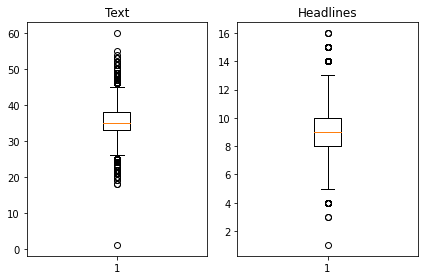

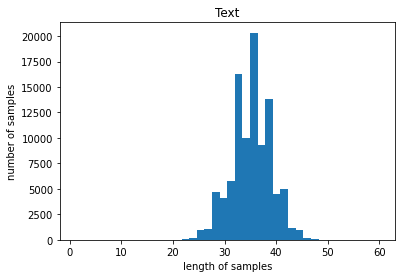

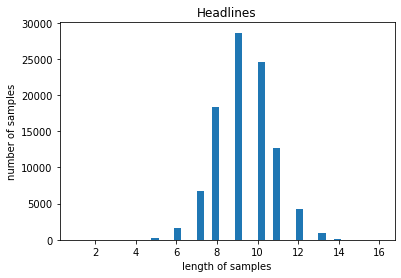

In [13]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
text_max_len = 50
headlines_max_len = 15

In [15]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [16]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9999694997966653


In [17]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98343


In [18]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [19]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [20]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[34527 73914  1054 ... 23867 96498 89051]


In [21]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [22]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19668


In [23]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78675
훈련 레이블의 개수 : 78675
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


In [24]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [25]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69765
등장 빈도가 6번 이하인 희귀 단어의 수: 47556
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22209
단어 집합에서 희귀 단어의 비율: 68.16598580950334
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.488687437111695


In [26]:
src_vocab = 22000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [27]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[540, 3806, 26, 819, 552, 99, 663, 4797, 3912, 3532, 74, 130, 3003, 492, 999, 938, 1112, 1769, 57, 6960, 1588, 7450, 4693, 1538, 483, 260, 324, 2005, 1424, 1097, 2026, 118, 304, 328, 108, 3532, 380], [159, 20, 60, 1171, 402, 544, 237, 4972, 83, 6639, 3736, 71, 67, 21, 1442, 505, 7781, 419, 402, 544, 180, 1061, 154, 6492, 505, 7781, 3100, 10974, 2453, 181, 21, 4751], [19431, 2739, 2320, 18398, 19432, 1009, 46, 177, 4287, 2321, 3411, 6179, 165, 1, 3946, 2181, 409, 234, 278, 43, 177, 33, 30, 760, 4287, 67, 2094, 1776, 573, 662, 165, 163, 765, 840, 257]]


In [28]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [29]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30167
등장 빈도가 5번 이하인 희귀 단어의 수: 19747
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10420
단어 집합에서 희귀 단어의 비율: 65.45894520502536
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.66862952058219


In [30]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 4385, 2206, 541, 5, 3784, 1834, 11, 507], [1, 67, 628, 3, 3591, 551, 935, 5637, 13, 2402], [1, 6180, 2759, 3680, 1980, 1399, 7, 3592, 942], [1, 1689, 2760, 13, 207, 290, 2159, 84, 199], [1, 264, 81, 36, 8, 2017, 4, 5901, 8186]]
target
decoder  [[4385, 2206, 541, 5, 3784, 1834, 11, 507, 2], [67, 628, 3, 3591, 551, 935, 5637, 13, 2402, 2], [6180, 2759, 3680, 1980, 1399, 7, 3592, 942, 2], [1689, 2760, 13, 207, 290, 2159, 84, 199, 2], [264, 81, 36, 8, 2017, 4, 5901, 8186, 2]]


In [31]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78674
훈련 레이블의 개수 : 78674
테스트 데이터의 개수 : 19668
테스트 레이블의 개수 : 19668


In [32]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

### Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [33]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [34]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [35]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [36]:
check_point = callbacks.ModelCheckpoint('GD-09.keras', save_best_only=True)
early_stopping = callbacks.EarlyStopping(verbose=1, patience=10, monitor='val_loss', restore_best_weights=True)
optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

history = model.fit(
    x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=512,
    callbacks=[check_point, early_stopping],
    epochs=100
)

Epoch 1/100
154/154 [==============================] - 142s 860ms/step - loss: 4.8156 - val_loss: 4.4624
Epoch 2/100
154/154 [==============================] - 131s 851ms/step - loss: 4.3454 - val_loss: 4.1630
Epoch 3/100
154/154 [==============================] - 132s 855ms/step - loss: 4.0847 - val_loss: 3.9618
Epoch 4/100
154/154 [==============================] - 130s 843ms/step - loss: 3.8673 - val_loss: 3.7739
Epoch 5/100
154/154 [==============================] - 130s 842ms/step - loss: 3.6796 - val_loss: 3.6392
Epoch 6/100
154/154 [==============================] - 129s 838ms/step - loss: 3.5260 - val_loss: 3.5332
Epoch 7/100
154/154 [==============================] - 129s 840ms/step - loss: 3.3963 - val_loss: 3.4538
Epoch 8/100
154/154 [==============================] - 129s 838ms/step - loss: 3.2832 - val_loss: 3.3685
Epoch 9/100
154/154 [==============================] - 129s 839ms/step - loss: 3.1813 - val_loss: 3.3090
Epoch 10/100
154/154 [==============================] -

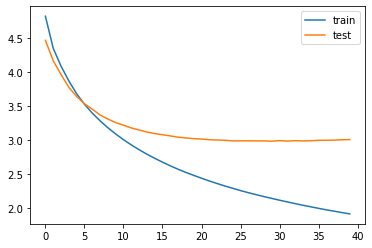

In [37]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [38]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [39]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [40]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [41]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [42]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [43]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : speaking rajinikanth starrer kaala dalit activist gujarat mla jignesh mevani tweeted watched kala yesterday felt also kala good film film oppression faced dalit community termed brilliant cultural response brahminical ideology mevani also shared photo kaala filmmaker pa ranjith 
실제 요약 : am also kaala mla jignesh mevani on new rajinikanth film 
예측 요약 :  rajinikanth shares poster of indu sarkar


원문 : scientists found evidence liquid water underneath south pole mars using radar measurements europe mars express orbiter probe detected km wide water body km beneath surface making first stable liquid water body found planet researchers said tried exhaust every possible alternative arrive conclusion 
실제 요약 : scientists find liquid water beneath mars surface 
예측 요약 :  water station may be brought into solar system study


원문 : gross fiscal states soared crore fiscal lakh crore fiscal marking increase according rbi data gap projected improve lakh crore fiscal notably rajasthan saw fiscal d

### Step 5. Summa을 이용해서 추출적 요약해보기

In [44]:
summa = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [45]:
# 데이터 전처리 함수
def preprocess_sentence_summa(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z.?]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [46]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in summa['text']:
    clean_text.append(preprocess_sentence_summa(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience. program upgrad degree career support helped transition data scientist tech mahindra salary hike. upgrad online power learning powered lakh careers.', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year. pranav kaushik delhi techie bagged reward spending cred coins. users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult.fit more.', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series. india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history.', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes. plan provides life cover age years. also customer

In [58]:
for i in range(50,100):
    print("\n원문 :", clean_text[i])
    print('Summary:')
    print(summarize(clean_text[i], ratio=0.5))


원문 : former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth crore dewan housing finance agencies including regulators government failed track nefarious deals said. comes media report tuesday accused dhfl controlling shareholders diverting funds shell companies buy assets.
Summary:
former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth crore dewan housing finance agencies including regulators government failed track nefarious deals said.

원문 : us based boeing wednesday reported annual sales worth billion first time planemaker sales crossed billion mark year history. company said expects deliver commercial aircraft boeing retained position world largest planemaker seventh straight year delivering aircraft
Summary:
us based boeing wednesday reported annual sales worth billion first time planemaker sales crossed billion mark year history.

원문 : text
Summary:


원문 : oneplus emerged india best selling premium smartpho

In [59]:
for i in range(50,100):
    print("\n원문 :", clean_text[i])
    print('Summary:')
    print(summarize(clean_text[i], words = 15))


원문 : former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth crore dewan housing finance agencies including regulators government failed track nefarious deals said. comes media report tuesday accused dhfl controlling shareholders diverting funds shell companies buy assets.
Summary:
former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth crore dewan housing finance agencies including regulators government failed track nefarious deals said.

원문 : us based boeing wednesday reported annual sales worth billion first time planemaker sales crossed billion mark year history. company said expects deliver commercial aircraft boeing retained position world largest planemaker seventh straight year delivering aircraft
Summary:
us based boeing wednesday reported annual sales worth billion first time planemaker sales crossed billion mark year history.

원문 : text
Summary:


원문 : oneplus emerged india best selling premium smartpho

In [50]:
!pwd

/aiffel/aiffel


In [53]:
! pip install openpyxl

     |████████████████████████████████| 249 kB 7.1 MB/s            


In [54]:
df1=pd.read_excel('/aiffel/aiffel/[GD-09]뉴스요약.xlsx')
df1

,실제 요약,실제 요약 번역,예측 요약,예측 요약 번역
0,scientists find liquid water beneath mars surface,화성 표면 아래 액체상태의 물 발견,water station may be brought into solar system...,태양계 연구에 급수소가 들어갈 수도
1,states fiscal deficit increased by to lakh cr,주 재정적자가 라크 크로어로 상승,april profit rises to crore in june quarter,6월 1분기에 4월 수입이 크로어로 상승
2,greek pm declares day of after bailout exit,그리스 총리가 구제금융 이후의 날을 선언하다,uk pm to hold economic deal with economic affairs,경제 문제와 경제 거래를 성사시킬 영국 총리
3,passenger records fatal plane crash in south a...,남아프리카에서 승객이 치명적인 비행기 추락 야기,plane carrying killed as plane crashes into plane,"수송기, 비행기에 추락해 사망"
4,tn man held for killing women by them with bricks,타밀 나두 출신 남자가 벽돌로 여성을 살해한 혐의로 붙잡히다,man arrested for cow slaughter in andhra pradesh,andhra pradesh에서 소를 도축한 죄로 한 남자가 잡히다
5,india us could be st century partnership obama,인도와 미국은 세기의 파트너가 될 수 있다고 오바마가 말했다,world no one world war with us president trump,세상 아무도 없음 미국 대통령 트럼프와 함께 하는 세계 전쟁
6,kim denies rumours of going bankrupt post spli...,"킴, 남편과 결별 후 파산설 부인",my wife will have been my wife says he is not ...,그는 전아내가 아니라고 내 부인이 내 부인일 것이라고 말한다.
7,lead in himachal shows people want to join pm ...,Himachal의 리드는 사람들이 Amit Shah 총리에 합류하기를 원한다는 것을...,pm modi will be in gujarat if we win shah,우리가 샤를 이긴다면 모디 총리는 구자라트에 있을 것입니다.
8,us startup to deliver its electric aircraft in,미국에서 전기 항공기를 인도하는 스타트업,startup to build world first electric aircraft\t,세계 최초의 전기 항공기를 만드는 스타트업
9,naked man jumps from first floor lands behind ...,벌거벗은 남자가 1층에서 뛰어내려 경찰 뒤에 착지,man accidentally found dead in front of his bo...,인도 델리에서 실수로 시신 앞에서 숨진 채 발견된 남성


원문과 예측 요약이 너무 따로 놀아서 성능이 꽤 좋지 않았다.

In [60]:
df2=pd.read_excel('/aiffel/aiffel/[GD-09]뉴스추출요약.xlsx')
df2

,원문,원문 번역,추출적 예측 요약,추출적 예측 요약 번역
0,former finance minister yashwant sinha tuesday...,전 재무장관 야슈완트 신하(yashwant sinha)는 화요일 규제 당국을 포함한...,former finance minister yashwant sinha tuesday...,전 재무장관 야슈완트 신하(yashwant sinha)는 화요일 규제 당국을 포함한...
1,us based boeing wednesday reported annual sale...,미국에 본사를 둔 보잉사는 수요일 처음으로 항공기 제조업체 매출이 10억 년 역사상...,us based boeing wednesday reported annual sale...,미국에 본사를 둔 보잉사는 수요일 처음으로 항공기 제조업체 매출이 10억 년 역사상...
2,oneplus emerged india best selling premium sma...,oneplus는 보고서 대위법에 따라 인도에서 가장 잘 팔리는 프리미엄 스마트폰 브...,oneplus emerged india best selling premium sma...,oneplus는 보고서 대위법에 따라 인도에서 가장 잘 팔리는 프리미엄 스마트폰 브...
3,filmmaker pooja bhatt talking presentation wom...,영화 제작자 pooja bhatt 이야기 프레젠테이션 여성 영화는 결코 여성의 몸을...,filmmaker pooja bhatt talking presentation wom...,영화 제작자 pooja bhatt 이야기 프레젠테이션 여성 영화는 결코 여성의 몸을...
4,actress mishti featured manikarnika queen jhan...,여배우 mishti 특집 manikarnika 여왕 jhansi는 영화 공동 감독인...,kangana said want dates characters look jumble...,kangana는 날짜를 원하는 캐릭터가 뒤죽박죽 보인다고 말했습니다...모두에게 눈...
5,high powered committee led pm narendra modi se...,고위위원회가 이끄는 PM Narendra Modi는 차기 CBI 이사를 선출하고 2...,high powered committee led pm narendra modi se...,고위위원회가 이끄는 PM Narendra Modi는 차기 CBI 이사를 선출하고 2...
6,nevada state athletic commission banned mma fi...,네바다 주 체육 위원회는 지난 10월 ufc와의 싸움에서 발생한 대규모 싸움이 발생...,nevada state athletic commission banned mma fi...,네바다 주 체육 위원회는 지난 10월 ufc와의 싸움에서 발생한 대규모 싸움이 발생...
7,pakistan captain sarfaraz ahmed banned four ma...,파키스탄 주장 사르파라즈 아흐메드는 4경기를 금지시켰고 인종차별적 발언은 아이가 트...,pakistan captain sarfaraz ahmed banned four ma...,파키스탄 주장 사르파라즈 아흐메드는 4경기를 금지시켰고 인종차별적 발언은 아이가 트...
8,banned cricketer sreesanth told supreme court ...,금지된 크리켓 선수 sreesanth는 처음에 델리 경찰이 IPL 스팟 고정 스캔들...,sreesanth said bookie tried dragging spot fixi...,sreesanth는 마권업자가 그것을 고정하는 지점을 드래그하려고 시도했다고 말했습니다.
9,finance ministry wednesday said government pre...,재무부는 수요일 정부가 2월 임시예산을 제시했고 전체예산이 회의에 제출될 것이라는 ...,finance ministry wednesday said government pre...,재무부는 수요일 정부가 2월 임시예산을 제시했고 전체예산이 회의에 제출될 것이라는 ...


In [65]:
df2.loc[:,'추출적 예측 요약':]

,추출적 예측 요약,추출적 예측 요약 번역
0,former finance minister yashwant sinha tuesday...,전 재무장관 야슈완트 신하(yashwant sinha)는 화요일 규제 당국을 포함한...
1,us based boeing wednesday reported annual sale...,미국에 본사를 둔 보잉사는 수요일 처음으로 항공기 제조업체 매출이 10억 년 역사상...
2,oneplus emerged india best selling premium sma...,oneplus는 보고서 대위법에 따라 인도에서 가장 잘 팔리는 프리미엄 스마트폰 브...
3,filmmaker pooja bhatt talking presentation wom...,영화 제작자 pooja bhatt 이야기 프레젠테이션 여성 영화는 결코 여성의 몸을...
4,kangana said want dates characters look jumble...,kangana는 날짜를 원하는 캐릭터가 뒤죽박죽 보인다고 말했습니다...모두에게 눈...
5,high powered committee led pm narendra modi se...,고위위원회가 이끄는 PM Narendra Modi는 차기 CBI 이사를 선출하고 2...
6,nevada state athletic commission banned mma fi...,네바다 주 체육 위원회는 지난 10월 ufc와의 싸움에서 발생한 대규모 싸움이 발생...
7,pakistan captain sarfaraz ahmed banned four ma...,파키스탄 주장 사르파라즈 아흐메드는 4경기를 금지시켰고 인종차별적 발언은 아이가 트...
8,sreesanth said bookie tried dragging spot fixi...,sreesanth는 마권업자가 그것을 고정하는 지점을 드래그하려고 시도했다고 말했습니다.
9,finance ministry wednesday said government pre...,재무부는 수요일 정부가 2월 임시예산을 제시했고 전체예산이 회의에 제출될 것이라는 ...


In [69]:
for i in range(len(df2)):
    print(df2['추출적 예측 요약'][i])
    print(df2['추출적 예측 요약 번역'][i],'\n')

former finance minister yashwant sinha tuesday demanded probe alleged diversion loans worth crore dewan housing finance agencies including regulators government failed track nefarious deals said.
전 재무장관 야슈완트 신하(yashwant sinha)는 화요일 규제 당국을 포함한 크로어 데완(crore dewan) 주택 금융 기관에 가치가 있는 전용 대출에 대한 조사를 요구했으며 정부는 사악한 거래를 추적하지 못했다고 말했습니다. 

us based boeing wednesday reported annual sales worth billion first time planemaker sales crossed billion mark year history.
미국에 본사를 둔 보잉사는 수요일 처음으로 항공기 제조업체 매출이 10억 년 역사상 처음으로 10억 달러에 달하는 연간 매출을 보고했습니다. 

oneplus emerged india best selling premium smartphone brand per report counterpoint.
oneplus는 보고서 대위법에 따라 인도에서 가장 잘 팔리는 프리미엄 스마트폰 브랜드로 부상했습니다. 

filmmaker pooja bhatt talking presentation women films said never look female body even naked vulgar manner.
영화 제작자 pooja bhatt 이야기 프레젠테이션 여성 영화는 결코 여성의 몸을 벌거벗은 저속한 방식으로 보지 말라고 말했습니다. 

kangana said want dates characters look jumbled up...i trying best give everybody prominent space screen.
kangana는 날짜를 원하는 캐릭터가 뒤죽박죽

오히려 추출적 예측 요약이 더 잘 요약한 것으로 보인다. 왜냐면 문맥에 맞게 잘 추출한 것 같기 때문이다.

In [70]:
card = pd.DataFrame({'문법완성도':['추상적 요약: 하', '추출적 요약: 하'],
                             '핵심단어 포함':['추상적 요약: X', '추출적 요약: O']})

In [71]:
card

,문법완성도,핵심단어 포함
0,추상적 요약: 하,추상적 요약: X
1,추출적 요약: 하,추출적 요약: O


### 회고

##### 어려웠던 점, 해결을 위해 시도한 방법, 문제해결에 성공한 이유 또는 실패한 이유
    : 추상적 요약 모델의 성능을 높이기 위해서 recurrent dropout도 적용했는데 그다지 나아지지 않았다. 추상적 요약은 정말 원문과 하나도 맞지 않는 소리를 해서 추출적 요약보다 더 성능이 안 좋았다.
    
##### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    : summa는 한 문장을 .을 기준으로 파악하기 때문에 전처리 과정에서 .이 빠지게 되면 문장을 파악하지 못해서 아무것도 실행되지 않은 것처럼 나온다.
    
##### 루브릭 평가 지표를 맞추기 위해 시도한 내용
    : 판다스 데이터프레임을 복습했다.
    
##### 자기 다짐, 프로젝트를 진행하면서 느낀점
    :데이터 분석을 초반에 했어서 그때는 판다스에 좀 익숙했는데 지금은 다 잊어버려서 데이터 처리가 힘들었다. 복습해야겠다. 추상적 요약 모델의 성능을 높이기 위해서 어떤 방식을 사용해야 할 지 모르겠다. nlp 공부를 해야겠다...